## Project summary
This project examines the factors that influence donation amounts in Cerebra’s telemarketing campaigns. 

## Research objectives:
1. **Identify distinct donor segments** based on their behaviours and build a predictive model.
2. Identify what donor and agent characteristics influence donation value.
3. **Estimate the value of the donation and calculate customer lifetime value** from the existing data set.

In [345]:
# import library
import pandas as pd 
import numpy as np

In [346]:
# read the data
donor = pd.read_csv('MAH 2025_dataset_final.csv')
donor.head()

,Donor_id,Donor_gender,Call_date,Call_time,Weekday,Session,Weekday_session,Campaign_type,Campaign_outcome,Amount,Pay_date,Pay_type,Call_pay_duration (days),Agent_id,Agent_age,Agent_origin,Agent_start_date
0,580730,Male,14/02/2018,12:02:45,Wednesday,afternoon,Wednesday_afternoon,DC,SL,10,23/02/2018,credit card,9,318,38.0,Welsh,24/02/2009
1,580780,Female,18/07/2018,12:28:34,Wednesday,afternoon,Wednesday_afternoon,DCW,SL,5,13/08/2018,cheque,26,531,25.0,Welsh,04/04/2014
2,580791,Male,13/11/2018,17:27:12,Tuesday,evening,Tuesday_evening,DCVH,SL,100,24/12/2018,cheque,41,543,27.0,Welsh,09/09/2014
3,580849,Female,19/11/2018,17:06:16,Monday,evening,Monday_evening,DC,SL,20,27/11/2018,cheque,8,522,32.0,Welsh,05/03/2014
4,580859,Female,20/02/2018,14:27:07,Tuesday,afternoon,Tuesday_afternoon,DC,DN,10,21/02/2018,credit card,1,633,25.0,Welsh,15/01/2018


In [347]:
donor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24518 entries, 0 to 24517
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Donor_id                  24518 non-null  int64  
 1   Donor_gender              24518 non-null  object 
 2   Call_date                 24518 non-null  object 
 3   Call_time                 24518 non-null  object 
 4   Weekday                   24518 non-null  object 
 5   Session                   24518 non-null  object 
 6   Weekday_session           24518 non-null  object 
 7   Campaign_type             24518 non-null  object 
 8   Campaign_outcome          24518 non-null  object 
 9   Amount                    24518 non-null  int64  
 10  Pay_date                  24518 non-null  object 
 11  Pay_type                  24518 non-null  object 
 12  Call_pay_duration (days)  24518 non-null  int64  
 13  Agent_id                  24518 non-null  int64  
 14  Agent_

In [348]:
# check for duplicate and drop duplicates
donor.duplicated().sum()

62

In [353]:
donor[donor.duplicated()]

,Donor_id,Donor_gender,Call_date,Call_time,Weekday,Session,Weekday_session,Campaign_type,Campaign_outcome,Amount,Pay_date,Pay_type,Call_pay_duration (days),Agent_id,Agent_age,Agent_origin,Agent_start_date


In [354]:
# drop duplicates
donor = donor.drop_duplicates()

In [355]:
# check the datashape after dropping duplicate
donor.shape

(24456, 17)

In [356]:
# see donor and donations distribution
# find the number of donors
unique_donors = donor["Donor_id"].nunique()
unique_donors

15826

In [357]:
# Number of donors (unique IDs) that appear more than once
num_duplicate_donors = (donor["Donor_id"].value_counts() > 1).sum()
num_duplicate_donors

6662

In [358]:
total_records = len(donor)

# Donations per donor distribution
donations_per_donor = donor.groupby("Donor_id")["Amount"].count()

# Summary stats
donation_summary = {
    "Total donations": total_records,
    "Unique donors": unique_donors,
    "Repeat Donors":num_duplicate_donors,
    "One time donor": unique_donors - num_duplicate_donors,
    "Average donations per donor": donations_per_donor.mean(),
    "Max donations by one donor": donations_per_donor.max(),
    "Median donations per donor": donations_per_donor.median()
}

donation_summary

{'Total donations': 24456,
 'Unique donors': 15826,
 'Repeat Donors': 6662,
 'One time donor': 9164,
 'Average donations per donor': 1.5453051939845823,
 'Max donations by one donor': 4,
 'Median donations per donor': 1.0}

## Short summary about donor and donations
- Total donations (rows): 24,456
- Unique donors: 15,826
- One-time donors: 9,164
- Repeat donors: 6,662 (≈ 42% of all donors)
- Most donors only gave once, and a minority gave 2–4 times.

In [359]:
# check missing value 
donor.isna().sum()

Donor_id                    0
Donor_gender                0
Call_date                   0
Call_time                   0
Weekday                     0
Session                     0
Weekday_session             0
Campaign_type               0
Campaign_outcome            0
Amount                      0
Pay_date                    0
Pay_type                    0
Call_pay_duration (days)    0
Agent_id                    0
Agent_age                   2
Agent_origin                2
Agent_start_date            2
dtype: int64

In [360]:
donor[donor.isna().any(axis=1)]

,Donor_id,Donor_gender,Call_date,Call_time,Weekday,Session,Weekday_session,Campaign_type,Campaign_outcome,Amount,Pay_date,Pay_type,Call_pay_duration (days),Agent_id,Agent_age,Agent_origin,Agent_start_date
2605,642288,Female,18/07/2018,09:54:31,Wednesday,morning,Wednesday_morning,DC,DN,50,19/07/2018,credit card,1,577,NaN,NaN,NaN
8876,789894,Female,15/01/2018,13:47:35,Monday,afternoon,Monday_afternoon,DC,SL,20,19/01/2018,cheque,4,512,NaN,NaN,NaN


In [361]:
donor = donor.dropna()

In [362]:
donor.shape

(24454, 17)

In [363]:
# new variable shows the agent year of working esperience
from datetime import datetime

# Make sure Agent_start_date is a datetime
donor["Agent_start_date"] = pd.to_datetime(donor["Agent_start_date"], dayfirst=True, errors="coerce")

# Today's date
today = pd.to_datetime("today")

# Calculate years of working
donor["Agent_years_working"] = (today - donor["Agent_start_date"]).dt.days / 365

In [364]:
donor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24454 entries, 0 to 24517
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Donor_id                  24454 non-null  int64         
 1   Donor_gender              24454 non-null  object        
 2   Call_date                 24454 non-null  object        
 3   Call_time                 24454 non-null  object        
 4   Weekday                   24454 non-null  object        
 5   Session                   24454 non-null  object        
 6   Weekday_session           24454 non-null  object        
 7   Campaign_type             24454 non-null  object        
 8   Campaign_outcome          24454 non-null  object        
 9   Amount                    24454 non-null  int64         
 10  Pay_date                  24454 non-null  object        
 11  Pay_type                  24454 non-null  object        
 12  Call_pay_duration (days

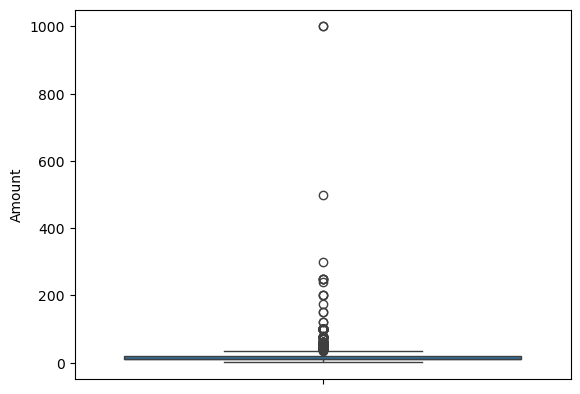

In [407]:
# check any outlier in the amount variable
import matplotlib.pyplot as plt 
import seaborn as sns

sns.boxplot(y='Amount', data=donor)
#sns.histplot(x='Amount', data=donor)
plt.show()

In [367]:
donor.sort_values(by="Amount", ascending=False).head(10)

,Donor_id,Donor_gender,Call_date,Call_time,Weekday,Session,Weekday_session,Campaign_type,Campaign_outcome,Amount,Pay_date,Pay_type,Call_pay_duration (days),Agent_id,Agent_age,Agent_origin,Agent_start_date,Agent_years_working
6943,744861,Male,30/07/2018,12:10:07,Monday,afternoon,Monday_afternoon,Multi-purpose,SL,1000,06/08/2018,cheque,7,530,32.0,Welsh,2014-05-06,11.356164
2328,634924,Male,01/08/2018,16:22:24,Wednesday,afternoon,Wednesday_afternoon,ILP,SL,1000,23/08/2018,cheque,22,505,67.0,Canadian,2014-01-27,11.627397
15981,958119,Female,26/06/2018,13:17:02,Tuesday,afternoon,Tuesday_afternoon,DCVH,DN,500,27/06/2018,credit card,1,530,32.0,Welsh,2014-05-06,11.356164
2355,635554,Female,23/07/2018,10:30:45,Monday,morning,Monday_morning,ILP,SL,300,04/10/2018,cheque,73,505,67.0,Canadian,2014-01-27,11.627397
11055,843273,Male,23/04/2018,16:03:10,Monday,afternoon,Monday_afternoon,Multi-purpose,SL,250,11/06/2018,cheque,49,530,32.0,Welsh,2014-05-06,11.356164
6989,745886,Male,17/10/2018,09:46:29,Wednesday,morning,Wednesday_morning,DCVH,SL,250,24/12/2018,cheque,68,398,40.0,Welsh,2011-06-21,14.232877
3049,651523,Female,07/03/2018,09:33:00,Wednesday,morning,Wednesday_morning,DC,SL,250,12/03/2018,cheque,5,530,32.0,Welsh,2014-05-06,11.356164
17231,988217,Female,16/04/2018,13:48:02,Monday,afternoon,Monday_afternoon,DC,SL,250,23/04/2018,cheque,7,398,40.0,Welsh,2011-06-21,14.232877
12064,867981,Male,01/08/2018,15:51:30,Wednesday,afternoon,Wednesday_afternoon,ILP,SL,240,06/08/2018,cheque,5,505,67.0,Canadian,2014-01-27,11.627397
3495,663373,Male,04/06/2018,15:42:57,Monday,afternoon,Monday_afternoon,DCVH,DN,200,05/06/2018,credit card,1,530,32.0,Welsh,2014-05-06,11.356164


## About the Amount variable 
- The distribution of the amount is skewed and has some extreme outliers
- The upper bound of the Amount is 35, most donors give less than 30, very few give above 50
- ACTION: **this variable is log-transformed for linear regression model**

In [368]:
# Create a new column with log-transformed donation amounts
donor["Amount_log"] = np.log1p(donor["Amount"])

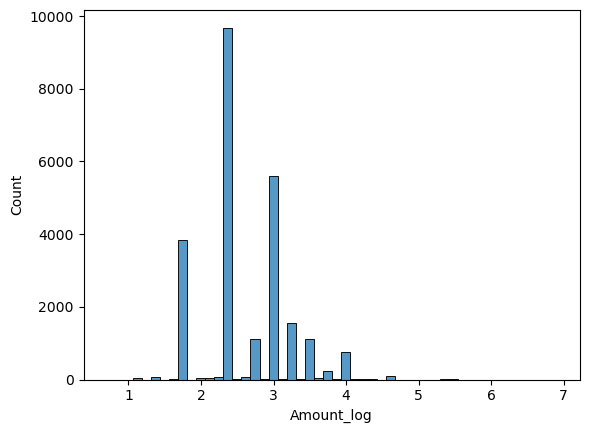

In [414]:
# viz the distribution again
sns.histplot(x='Amount_log', data=donor, bins=50)
plt.show()

## Descriptive Statistics

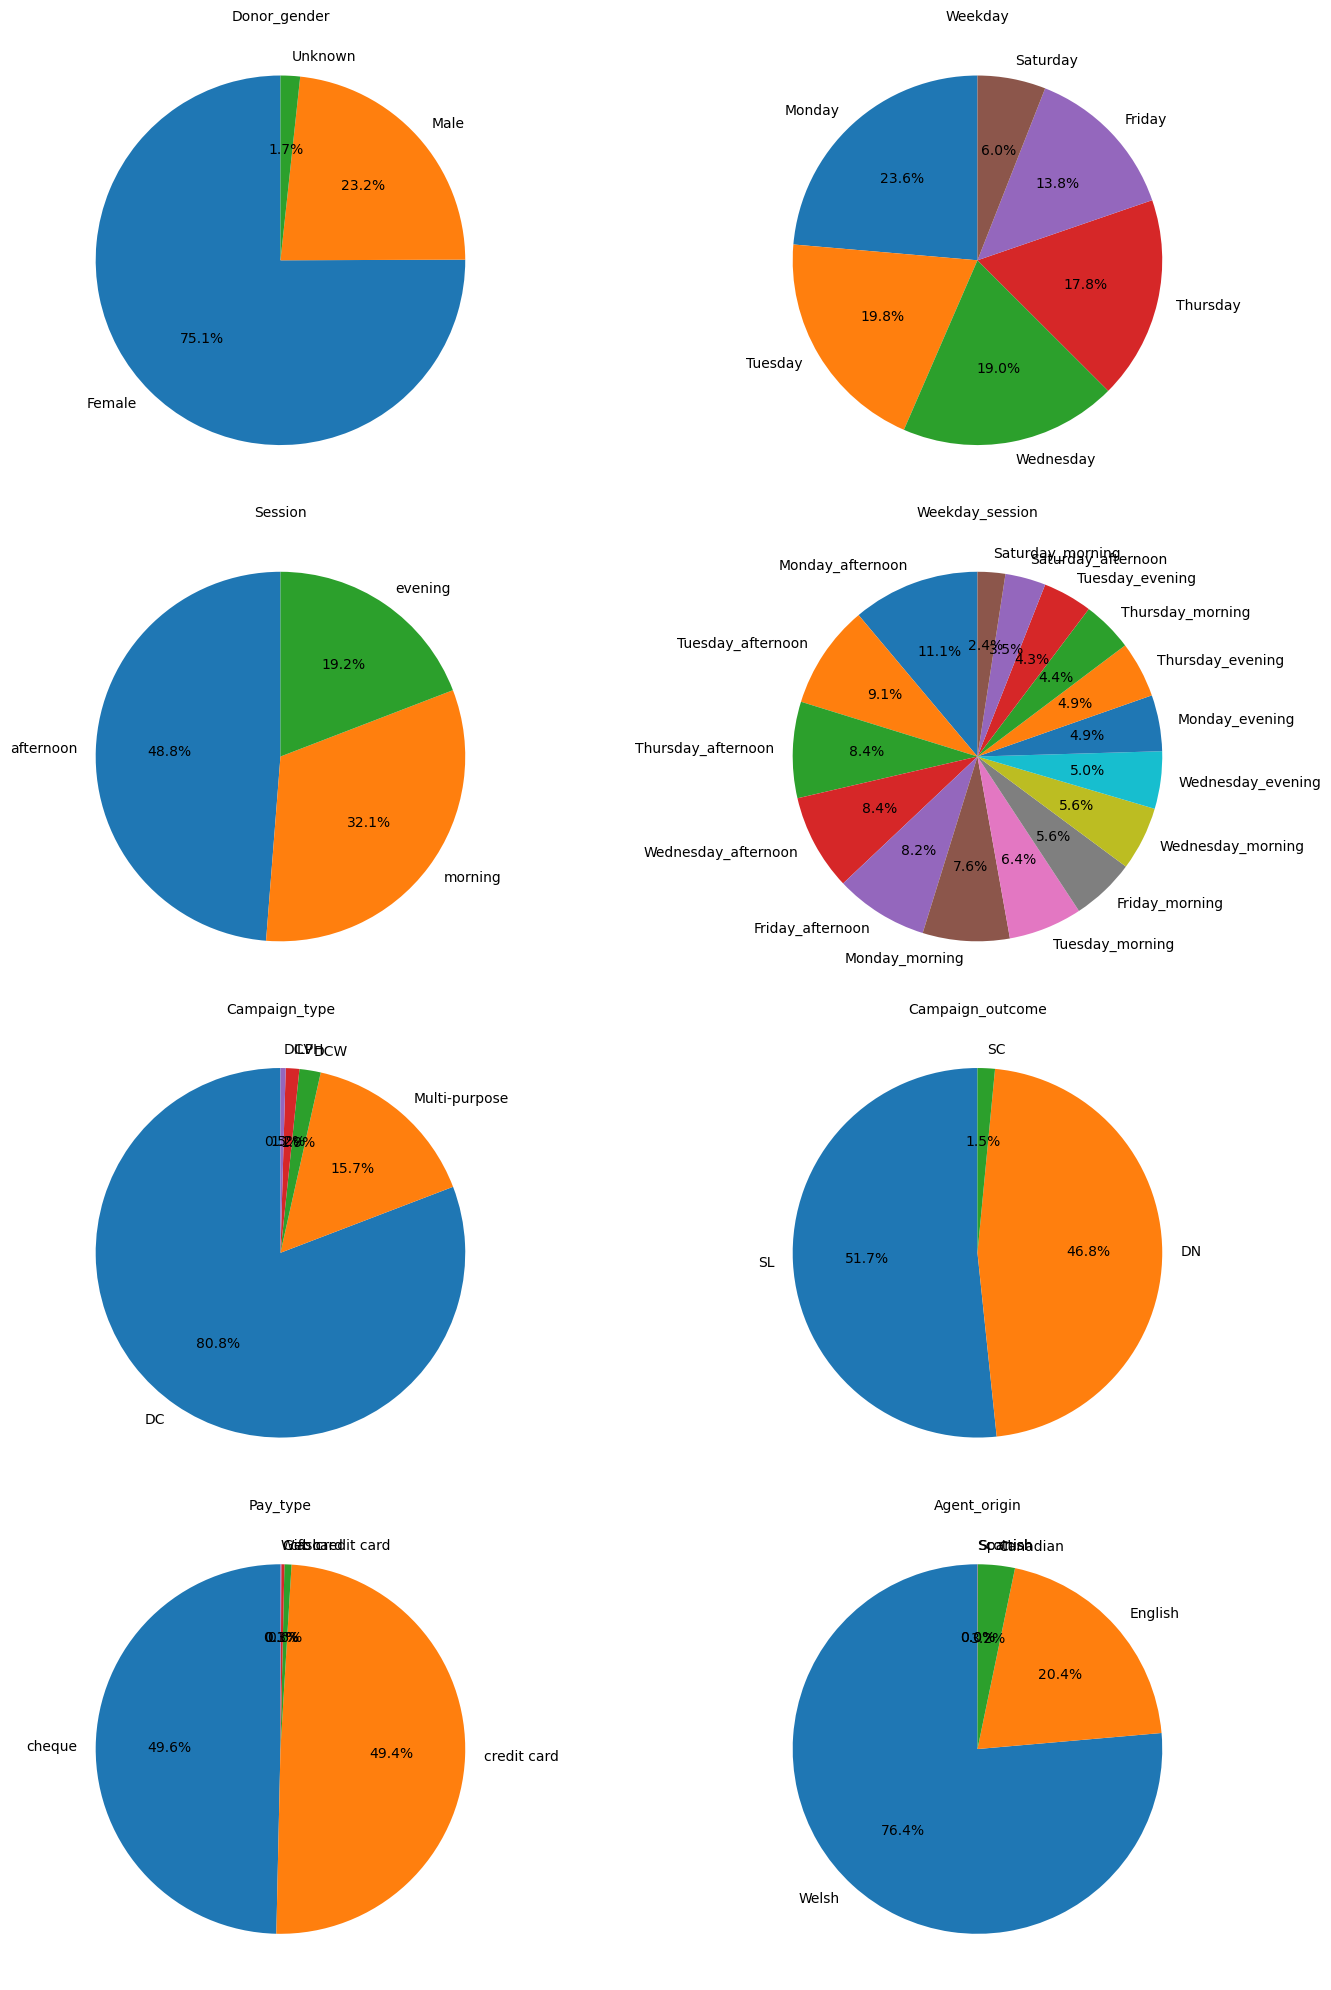

In [373]:
### Descriptive Statistics for categorical variablesabs
import math
# List of categorical columns (excluding the DV itself)
categorical_cols = ['Donor_gender','Weekday','Session','Weekday_session','Campaign_type','Campaign_outcome','Pay_type','Agent_origin']  # Add more if needed

# Set number of charts per row
charts_per_row = 2
total_vars = len(categorical_cols)
rows = math.ceil(total_vars / charts_per_row)

# Create subplots
fig, axes = plt.subplots(rows, charts_per_row, figsize=(15, rows * 5))
axes = axes.flatten()  # flatten in case of multiple rows

for i, var in enumerate(categorical_cols):
    counts = donor[var].value_counts(dropna=False)
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(var, fontsize=10)

# Hide unused subplots if variables are not a multiple of 4
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

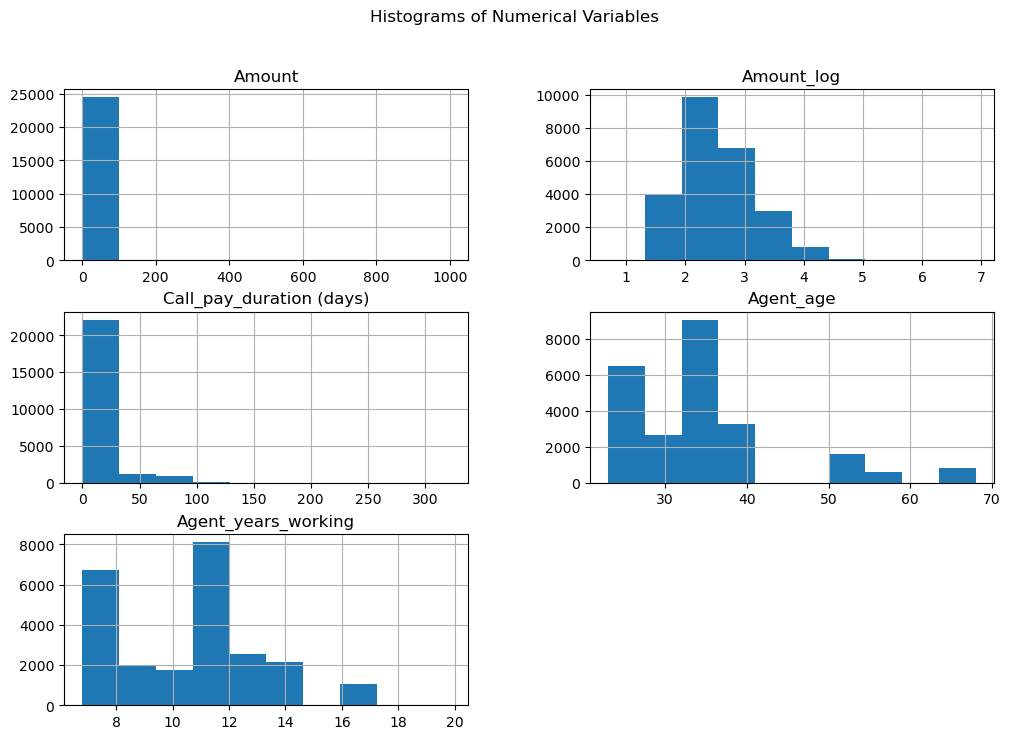

In [374]:
num_vars = ['Amount','Amount_log','Call_pay_duration (days)','Agent_age','Agent_years_working']
donor[num_vars].hist(bins=10, figsize=(12,8))
plt.suptitle("Histograms of Numerical Variables")
plt.show()

## Descriptive Analysis

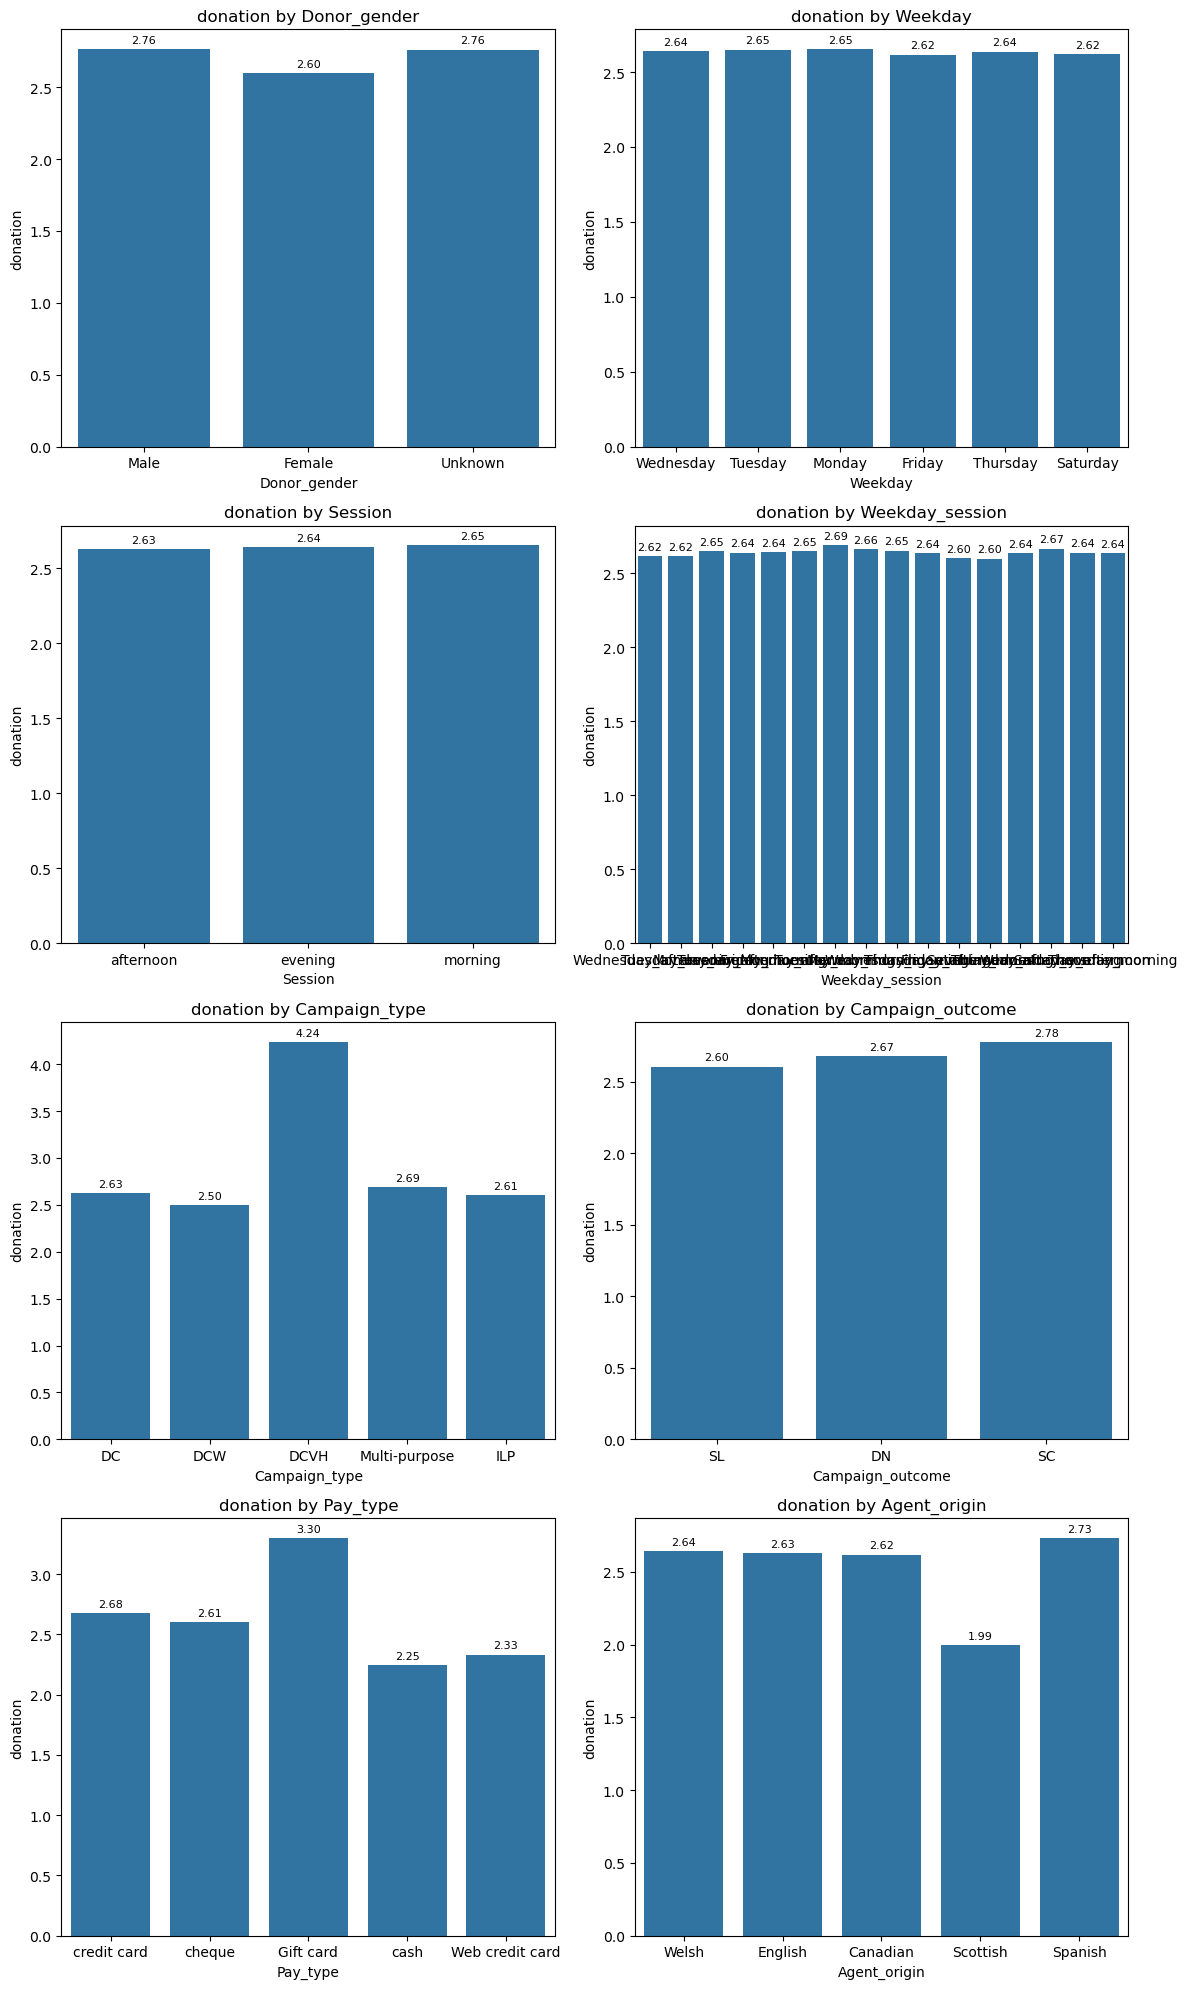

In [375]:
# find categorical variables
categorical_cols = ['Donor_gender','Weekday','Session','Weekday_session','Campaign_type','Campaign_outcome','Pay_type','Agent_origin']  # Add more if needed


# Set up subplot grid
n_cols = 2
n_rows = (len(categorical_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

# Loop categorical colunms
for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.barplot(x=col, y='Amount_log', data=donor, ax=axes[i], errorbar=None)
    axes[i].set_title(f'donation by {col}')
    axes[i].set_ylabel('donation')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x')

# Annotate values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=3)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [376]:
# Anova test
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# One-way ANOVA
model = ols('Amount_log ~ C(Q("Agent_origin"))', data=donor).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Tukey HSD post-hoc test
tukey = pairwise_tukeyhsd(endog=donor["Amount_log"],
                          groups=donor["Agent_origin"],
                          alpha=0.05)

print(tukey)

                           sum_sq       df         F    PR(>F)
C(Q("Agent_origin"))     2.359777      4.0  1.795538  0.126607
Residual              8032.992478  24449.0       NaN       NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Canadian  English   0.0121 0.9816 -0.0477  0.072  False
Canadian Scottish  -0.6244 0.3265 -1.5289 0.2801  False
Canadian  Spanish   0.1132 0.9949 -0.6706  0.897  False
Canadian    Welsh   0.0253 0.7414 -0.0315 0.0821  False
 English Scottish  -0.6365 0.3051 -1.5396 0.2666  False
 English  Spanish    0.101 0.9967 -0.6811 0.8832  False
 English    Welsh   0.0132 0.5994 -0.0117 0.0381  False
Scottish  Spanish   0.7375 0.4435 -0.4568 1.9318  False
Scottish    Welsh   0.6497 0.2843 -0.2532 1.5526  False
 Spanish    Welsh  -0.0878 0.9981 -0.8698 0.6941  False
-------------------------------------------------------


## Note for statistical test
- gender: keep
- weekdays: Friday is slightly higher than Monday, but the effect is small
- Session: keep
- Weekday_session: keep
- Pay type: keep
- Agent_origin: p-value is high but keep to see the effect

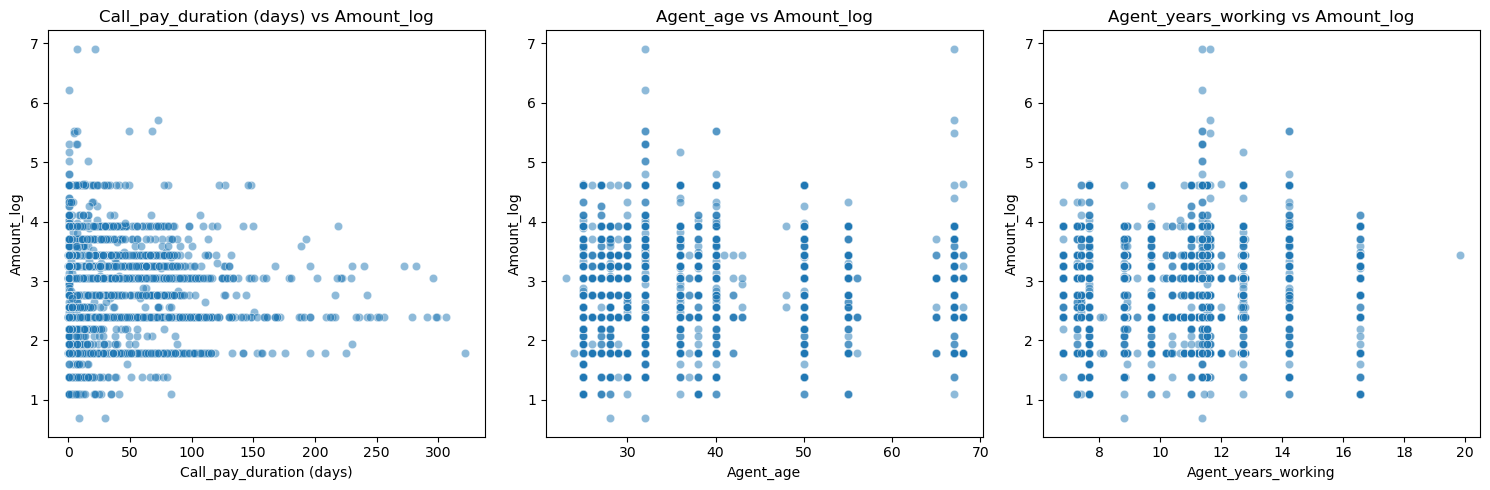

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns

num_vars = ['Call_pay_duration (days)', 'Agent_age', 'Agent_years_working']

plt.figure(figsize=(15, 5))

for i, var in enumerate(num_vars, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=donor[var], y=donor["Amount_log"], alpha=0.5)
    plt.title(f"{var} vs Amount_log")
    plt.xlabel(var)
    plt.ylabel("Amount_log")

plt.tight_layout()
plt.show()

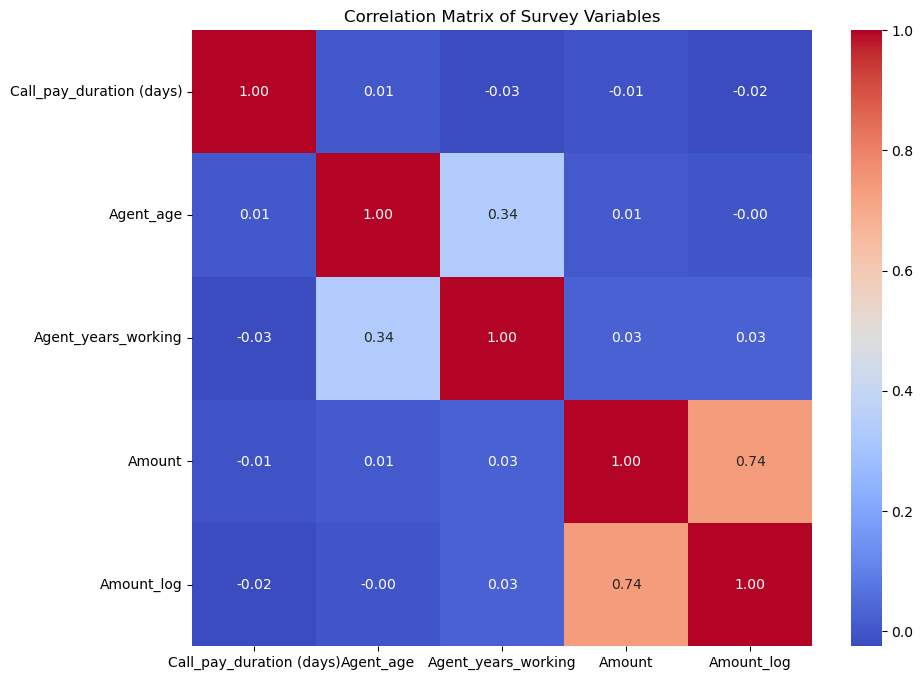

In [378]:
# correlation matrix for numerical data in this dataset
num_vars = donor[['Call_pay_duration (days)', 'Agent_age', 'Agent_years_working','Amount','Amount_log']]
correlation_matrix = num_vars.corr()

# Create a heatmap
plt.figure(figsize=(10, 8)) # You can adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Survey Variables')
plt.show()

## Note for the correlation test
- numerical variable has low impact in donation amount

## Predictive modelling

In [391]:
#select variables for predictive modelling
columns_to_drop = ['Donor_id','Call_date','Call_time','Call_pay_duration (days)','Agent_id','Agent_age',
                   'Agent_start_date','Agent_years_working','Pay_date','Weekday_session']
donor_modelling = donor.copy()
donor_modelling.drop(columns=columns_to_drop, inplace=True)

In [392]:
donor_modelling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24454 entries, 0 to 24517
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Donor_gender      24454 non-null  object 
 1   Weekday           24454 non-null  object 
 2   Session           24454 non-null  object 
 3   Campaign_type     24454 non-null  object 
 4   Campaign_outcome  24454 non-null  object 
 5   Amount            24454 non-null  int64  
 6   Pay_type          24454 non-null  object 
 7   Agent_origin      24454 non-null  object 
 8   Amount_log        24454 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.9+ MB


In [393]:
import pandas as pd
import statsmodels.api as sm

# 1. Define y and X
y = donor_modelling["Amount_log"]
X = donor_modelling.drop(columns=["Amount", "Amount_log"])

# 2. One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True, dtype=float)

# 3. Drop any missing values & align
df = pd.concat([y, X], axis=1).dropna()
y = df["Amount_log"].astype(float)
X = df.drop(columns=["Amount_log"]).astype(float)

# 4. Add intercept
X = sm.add_constant(X)

# 5. Fit OLS regression
ols = sm.OLS(y, X).fit()

# 6. Show results
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:             Amount_log   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     71.20
Date:                Wed, 10 Sep 2025   Prob (F-statistic):          1.05e-321
Time:                        15:36:38   Log-Likelihood:                -20297.
No. Observations:               24454   AIC:                         4.064e+04
Df Residuals:                   24430   BIC:                         4.084e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [421]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# ==== data ====
df = donor_modelling.copy()

y = df["Amount_log"]
X = df.drop(columns=["Amount_log", "Amount", "Pay_date"], errors="ignore")

# columns by type
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

# preprocessing: one-hot categorical, passthrough numeric
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# pipeline
lin_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

# fit
lin_pipe.fit(X_train, y_train)

# predictions (log scale)
y_pred = lin_pipe.predict(X_test)

# metrics
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Linear Regression (Amount_log)")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ===== coefficient table =====
# get feature names for the transformed matrix
ohe = lin_pipe.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)  # e.g., 'Weekday_Monday'
feature_names = np.r_[cat_feature_names, num_cols]

coefs = lin_pipe.named_steps["model"].coef_
intercept = lin_pipe.named_steps["model"].intercept_

coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Exp(Coefficient)": np.exp(coefs),
    "Pct_change": (np.exp(coefs) - 1) * 100   # % interpretation
}).sort_values("Coefficient", ascending=False).reset_index(drop=True)


print(coef_table)

print(f"\nIntercept: {intercept:.4f}")


Linear Regression (Amount_log)
R²:   0.0499
MAE:  0.4622
RMSE: 0.5577
                        Feature  Coefficient  Exp(Coefficient)  Pct_change
0            Campaign_type_DCVH     1.245748          3.475533  247.553256
1            Pay_type_Gift card     0.619860          1.858668   85.866818
2          Agent_origin_Spanish     0.267584          1.306804   30.680385
3            Agent_origin_Welsh     0.123047          1.130938   13.093806
4           Campaign_outcome_SC     0.112543          1.119120   11.911997
5          Pay_type_credit card     0.086866          1.090750    9.075049
6          Agent_origin_English     0.074719          1.077581    7.758085
7         Agent_origin_Canadian     0.068894          1.071322    7.132235
8             Donor_gender_Male     0.063976          1.066066    6.606639
9          Donor_gender_Unknown     0.027671          1.028057    2.805744
10              Pay_type_cheque     0.014307          1.014410    1.441003
11            Weekday_Wednesda

## Business Implication from the predictive model
### Key Insights from Regression Analysis (DV = Amount_log)
1. Campaign_type (Level 1)
1_DCVH (donated > £50 in last 9 years) → +248% higher donations (best performing).
1_DC (donated ≤ £50 in last 9 years), 1_DCW (donated >9 years ago), 1_Multi-purpose (donate or buy lottery tickets), 1_ILP (inactive lottery players) → 20–33% lower donations.
 Implication: Prioritize 1_DCVH campaigns. Reassess strategies for DC, DCW, Multi-purpose, ILP segments as they yield smaller average donations.
2. Campaign_outcome (Level 2)
2_SC (coin card request) → +12% higher donations.
2_DN (donation via phone card payment) and 2_SL (donation letter request) → 5–6% lower donations.
Implication: Emphasize 2_SC campaigns. Audit DN/SL workflows — are they cannibalizing larger donations?
3. Payment Method
Gift card (+86%) and Credit card (+9%) yield larger donations.
Cash (–29%), Web credit card (–32%), Cheque (–1%) perform worse.
Implication: Train callers to nudge donors toward gift cards or standard credit cards. Consider discouraging cash/web credit card options for higher ask amounts.
4. Donor Gender
Male (+6.6%) and Unknown (+2.8%) give more than Female (–8.8%).
Implication:
With male/unknown donors, telemarketers can push for higher pledges.
With female donors, focus on participation rate/volume rather than high-value asks.
5. Agent Origin
Spanish (+31%), Welsh (+13%), English (+8%) agents outperform.
Scottish agents (–41%) underperform significantly.
Implication: Route high-value donors to top-performing agents; provide training/support for Scottish agents.
6. Timing (Weekday/Session)
Effects are minimal (±3%).
Implication: Do not over-invest in scheduling optimization; focus instead on campaign content and payment strategy.

### Strategic Recommendations
1. Double down on high-performing campaigns (1_DCVH + 2_SC).
- Allocate more budget and telemarketing hours here.
- Use stronger ask scripts for these segments.

2. Restructure or phase out weak campaigns (1_DC, 1_DCW, 1_ILP, 1_Multi-purpose).
- Explore alternative engagement strategies (e.g., smaller asks, lottery incentives).

3. Optimize payment channels.
- Encourage gift card or credit card donations.
- Limit reliance on cash/web credit card.

4. Segment donor asks by gender.
- Males/Unknown → push higher amounts.
- Females → emphasize joining/retention.

5. Improve agent performance.
- Route high-value donors to Spanish/Welsh/English agents.
- Provide training for Scottish agents to improve conversion.

In [423]:
# try other ML algorithms
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.0 MB/s eta 0:00:00a 0:00:01


In [424]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ----- Data -----
df = donor_modelling.copy()
y = df["Amount_log"]
X = df.drop(columns=["Amount_log", "Amount", "Pay_date"], errors="ignore")

# Column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Random Forest =====
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400, max_depth=None, n_jobs=-1, random_state=42
    ))
])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("Random Forest Results")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))

# ===== XGBoost =====
xgb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", XGBRegressor(
        n_estimators=400, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        n_jobs=-1, objective="reg:squarederror"
    ))
])
xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)

print("\nXGBoost Results")
print("R²:", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", root_mean_squared_error(y_test, y_pred_xgb))


Random Forest Results
R²: 0.018643998996528355
MAE: 0.4664732925086708
RMSE: 0.5667959684090158

XGBoost Results
R²: 0.012285552632024688
MAE: 0.46749157414084475
RMSE: 0.5686292087881484


## Cluster analysis

In [432]:
donor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24454 entries, 0 to 24517
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Donor_id                  24454 non-null  int64         
 1   Donor_gender              24454 non-null  object        
 2   Call_date                 24454 non-null  object        
 3   Call_time                 24454 non-null  object        
 4   Weekday                   24454 non-null  object        
 5   Session                   24454 non-null  object        
 6   Weekday_session           24454 non-null  object        
 7   Campaign_type             24454 non-null  object        
 8   Campaign_outcome          24454 non-null  object        
 9   Amount                    24454 non-null  int64         
 10  Pay_date                  24454 non-null  object        
 11  Pay_type                  24454 non-null  object        
 12  Call_pay_duration (days

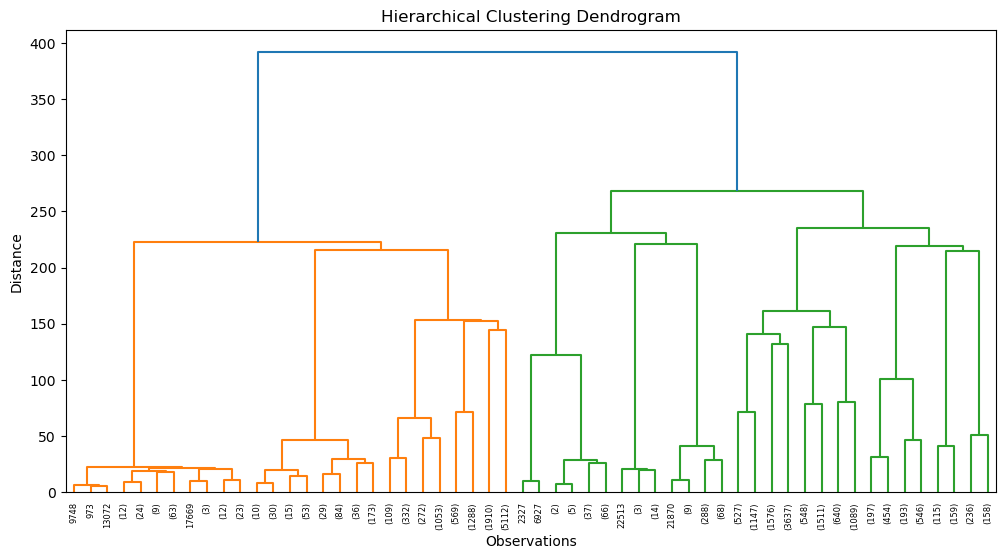

In [433]:
### cluster analysis hierarchical
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Drop demographic and DV variables
columns_to_exclude = ['Donor_id','Call_date','Call_time','Weekday_session','Pay_date','Agent_id','Agent_age','Agent_origin','Agent_start_date',
                     'Agent_years_working','Amount_log']  

cluster_vars = donor.drop(columns=columns_to_exclude, errors='ignore')

# 2. One-hot encode categorical variables
cluster_vars_encoded = pd.get_dummies(cluster_vars, drop_first=True)

# 3. Standardise data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_vars_encoded)

# 4. Create linkage matrix using Ward’s method
Z = linkage(X_scaled, method='ward')

# 5. Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # truncate for readability
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

# cluster 2-4 are all possible from the dendrogram

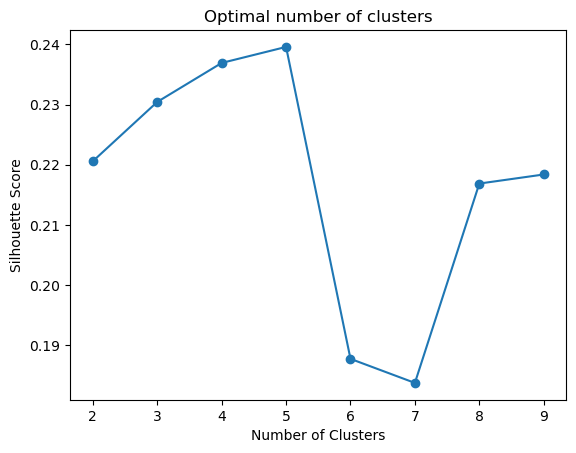

In [434]:
### cluster analysis K-means
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Select relevant variables for clustering
cluster_vars = donor.drop(columns=['Donor_id','Call_date','Call_time','Weekday_session','Pay_date','Agent_id','Agent_age','Agent_origin','Agent_start_date',
                     'Agent_years_working','Amount_log'], errors='ignore')

# Step 2: One-hot encode categorical variables
cluster_vars_encoded = pd.get_dummies(cluster_vars, drop_first=True)

# Step 3: Standardize the data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_vars_encoded)

# Step 4: Find optimal number of clusters (optional, using silhouette score)
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    labels = kmeans.fit_predict(cluster_scaled)
    silhouette_scores.append(silhouette_score(cluster_scaled, labels))

# Plot silhouette scores (optional)
import matplotlib.pyplot as plt
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal number of clusters')
plt.show()

# 5-cluster solution reaches the highest silhouette_score, therefore used as the solution

In [445]:
#  Run KMeans with chosen number of clusters
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=1000)  # change n_clusters=_ to your chosen k
donor['Cluster_5'] = kmeans_final.fit_predict(X_scaled)

In [ ]:
# # drop cluster columns if needed
# donor=donor.drop(columns=['Cluster_5'])

In [448]:
# cluster profiling
# Drop Loan_ID and Loan_Status as they are not needed for profiling
df_for_profiling = donor.drop(columns=['Donor_id','Call_date','Call_time','Weekday_session','Pay_date','Agent_id',
                                       'Agent_origin','Agent_start_date','Agent_age','Agent_years_working','Amount_log','Cluster_5'], errors='ignore')

# Identify numerical and categorical columns
# We will use one-hot encoding for the categorical columns
categorical_cols = ['Donor_gender','Weekday','Session','Campaign_type','Campaign_outcome','Pay_type']

# One-hot encode the categorical variables, then group by cluster and calculate the mean
df_encoded = pd.get_dummies(df_for_profiling, columns=categorical_cols)

# Group by 'Cluster_4' and calculate the mean for all columns
# The mean of the one-hot encoded columns will show the proportion of each category
cluster_profile = df_encoded.groupby('Cluster_4').mean().round(2)

# Transpose the DataFrame for better readability
cluster_profile_transposed = cluster_profile.transpose()

print("Transposed Cluster Profile (Clusters as Columns):")
print(cluster_profile_transposed)

Transposed Cluster Profile (Clusters as Columns):
Cluster_4                        0      1      2      3
Amount                       17.44  14.91  15.91  96.33
Call_pay_duration (days)     39.77  21.84   2.01  17.19
Donor_gender_Female           0.79   0.75   0.75   0.46
Donor_gender_Male             0.18   0.23   0.23   0.48
Donor_gender_Unknown          0.02   0.01   0.02   0.06
Weekday_Friday                0.14   0.14   0.14   0.03
Weekday_Monday                0.25   0.24   0.23   0.33
Weekday_Saturday              0.05   0.06   0.06   0.01
Weekday_Thursday              0.20   0.17   0.18   0.03
Weekday_Tuesday               0.17   0.20   0.19   0.35
Weekday_Wednesday             0.19   0.19   0.19   0.26
Session_afternoon             0.50   0.49   0.48   0.29
Session_evening               0.23   0.19   0.19   0.10
Session_morning               0.28   0.31   0.33   0.61
Campaign_type_DC              0.87   0.90   0.72   0.00
Campaign_type_DCVH            0.00   0.00   0.00   0.9

In [447]:
# cluster distribution
donor['Cluster_4'].value_counts()

Cluster_4
1    12152
2    11805
0      384
3      113
Name: count, dtype: int64

In [455]:
import pandas as pd

# Ensure Pay_date is datetime
donor["Pay_date"] = pd.to_datetime(donor["Pay_date"], errors="coerce", dayfirst=True)

# Group by donor to get frequency, total, and average
clv_table = donor.groupby("Donor_id").agg(
    Frequency=("Amount", "count"),          # number of donations
    Recency=("Pay_date", lambda x: (donor["Pay_date"].max() - x.max()).days),  # days since last gift
    Monetary=("Amount", "mean"),            # average donation size
    Total_Value=("Amount", "sum")           # total donated historically
).reset_index()

# Simple historical CLV = Average donation * Frequency
clv_table["CLV_simple"] = clv_table["Frequency"] * clv_table["Monetary"]

clv_table.head()


,Donor_id,Frequency,Recency,Monetary,Total_Value,CLV_simple
0,580730,1,304,10.0,10,10.0
1,580780,1,133,5.0,5,5.0
2,580791,1,0,100.0,100,100.0
3,580849,1,27,20.0,20,20.0
4,580859,3,28,10.0,30,30.0


In [456]:
cluster_clv = donor.merge(clv_table[["Donor_id", "CLV_simple"]], on="Donor_id")
cluster_summary = cluster_clv.groupby("Cluster_4")["CLV_simple"].mean().sort_values(ascending=False)
print(cluster_summary)

Cluster_4
3    133.159292
2     30.136383
1     27.411537
0     25.018229
Name: CLV_simple, dtype: float64


## Cluster Profiling

### Cluster 1 — “Letter Responders” (12,152 donors, ~50%)
- Avg. donation: £14.91 (lowest).
- Avg. CLV: £27.41 (low).
- Payment: 97% cheque.
- Campaigns: 90% DC, 100% SL (donation letters).
- Gender: 75% female.
- Session: balanced morning/afternoon.
- Persona: Mostly older female donors, prefer donating by cheque in response to letters.
- Targeting: Low ROI. Keep via low-cost mail campaigns. CLV shows they are not worth heavy telemarketing investment — retention only.

### Cluster 2 — “Card Givers” (11,805 donors, ~48%)
- Avg. donation: £15.91.
- Avg. CLV: £30.14 (moderate).
- Payment: 100% credit card.
- Campaigns: 72% DC, 97% DN (phone donations).
- Gender: 75% female.
- Session: slightly more mornings.
- Persona: Younger female donors, comfortable giving over the phone by credit/debit card. Efficient telemarketing donors.
- Targeting: Growth cluster. CLV indicates solid medium-term value. Use telemarketing actively — push higher ask amounts and consider cross-sell into lotteries.

### Cluster 0 — “Cheque-First Traditionalists” (384 donors, ~1.5%)
- Avg. donation: £17.44.
- Avg. CLV: £25.02 (lowest).
- Payment: 84% cheque, 11% credit card.
- Campaigns: 87% DC, 96% SC (coin-card outcome).
- Gender: 79% female.
- Session: afternoon-heavy.
- Persona: Small group of traditional cheque donors, strongly responsive to coin-card campaigns.
- Targeting: Maintain but don’t expand. CLV is lowest, and the segment is small. Focus only on cheap retention.

### Cluster 3 — “High-Value VH Donors” (113 donors, ~0.5%)
- Avg. donation: £96.33 (6× higher than others 🚀).
- Avg. CLV: £133.16 (highest).
- Payment: 42% credit card, 54% cheque, 4% gift card.
- Campaigns: 98% DCVH (donated >£50 in last 9 years).
- Outcomes: 60% SL, 38% DN.
- Gender: balanced (46% female, 48% male, 6% unknown).
- Session: mornings (61%).
- Persona: Small elite group of high-value donors, mixed payment types, strong giving history.
- Targeting: Top priority cluster. CLV confirms they are the revenue engine. Treat as major donor prospects — personal calls, morning timing, possibly invite to VIP/legacy campaigns.

## Business Summary
1. **Revenue engine = Cluster 3 (VIP donors, CLV £133)** → treat as high-touch, major donor cultivation.
2. **Mass base = Cluster 2 (card donors, CLV £30)** → scalable telemarketing campaigns, good upgrade potential.
3. **Retention = Cluster 1 (letter/cheque donors, CLV £27)** → maintain via low-cost mail, avoid heavy telemarketing.
4. **Small traditionalists = Cluster 0 (CLV £25)** → minimal effort, only basic retention.
